In [9]:
import os
import imageio
import skimage.transform
import numpy as np
import pandas as pd
import tifffile
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm
import cv2
from PIL import Image
import math

In [11]:
                                                        #Set Paths

#movies
movie_low = '/Users/djuanm/Documents/Behavior_Analysis /Videos/M181-20241215-185048-lower-camera.mp4'
movie_side = '/Users/djuanm/Documents/Behavior_Analysis /Videos/M181-20241215-185048-side-camera.mp4'
movie_upper = '/Users/djuanm/Documents/Behavior_Analysis /Videos/M181-20241215-185048-upper-camera.mp4'

#CSVs
csv_low = '/Users/djuanm/Documents/Behavior_Analysis /Data/M181-20241215-185048-lower-camera.csv'
csv_side = '/Users/djuanm/Documents/Behavior_Analysis /Data/M181-20241215-185048-side-camera.csv'
csv_upper = '/Users/djuanm/Documents/Behavior_Analysis /Data/M181-20241215-185048-upper-camera.csv'

plots = '/Users/djuanm/Documents/Behavior_Analysis /Plots/'

view =['low','side','top']
movies = [movie_low,movie_side,movie_upper]

In [ ]:
#THIS IS THE CORRECT CODE, CLEAN EVERYTHING AND REFER TO THIS!!! - 9/20


                                            #Load up videos and images - 9/10
v = 0

for movie in movies:
    # Load up frames
    frame_fraction = 0
    seconds_to_save = 20#60
    
    #Load video
    vid = imageio.get_reader(movie, 'ffmpeg')
    
    #Get fps, length, start frmae
    fps = vid.get_meta_data()['fps']
    length = fps*vid.get_meta_data()['duration']
    start_frame = int(frame_fraction * length)
    
    #initialize list to save each image in a frame
    stack_to_save = []
    rng = np.arange(int(start_frame), int(start_frame + fps*seconds_to_save))
    
    #Save each frame from video as image - tqdm just adds a progress bar
    for stk in tqdm(rng):
        stack_to_save.append(vid.get_data(stk))
    
    
    
    # Save out frames as image
    img_low_list = []
    #Converts each image to a single tif file with each image
    with tifffile.TiffWriter(os.path.split(movie_side)[0] + os.path.sep + os.path.split(movie_side)[1][:-4] + '-chunk.tif', imagej=True) as tif:
        for img in tqdm(stack_to_save):
             tif.write(img, contiguous=True)
    
    
                                            #Load frames and images into dataframe - 9/10
    
    #Label each frame and save into dataframe
    frame_num = list(range(len(stack_to_save)))
    frame_list = []
    for i in frame_num:
        frame_name = 'frame' + str(frame_num[i])
        frame_list.append(frame_name)
    
    #Create DataFrame
    df = pd.DataFrame()
    df['Frame_number'] = frame_list
    df['Frame_array'] = stack_to_save
    
    
                                                #Create ROI - 9/10
                                                     
    #Select random frame to choose ROI - roi in terms of [Top_Left_X, Top_Left_Y, Width, Height]
    random_frame = df.sample()
    img = random_frame['Frame_array'].iloc[0]
    roi = cv2.selectROI('Select ROI', img, showCrosshair=True, fromCenter=False)
    cv2.waitKey(0) 
    cv2.destroyAllWindows()
    
    #Get beginning and end indices for roi width
    roi_x1 = roi[0]
    roi_x2 = roi_x1 + roi[2]
    
    #Get beginning and end indices for roi height
    roi_y1 = roi[1]
    roi_y2 = roi_y1 + roi[3]
    
    
                                                        #Crop image array to ROI - 9/12
    
    list_array_cropped = []
    dict_array_cropped = {}
    
    #Iterate through each array and crop them
    for idx, row in df.iterrows():
        array = df['Frame_array'][idx]
    
        #Get height and width of image - should be the same 
        h_img, w_img, RGB = np.shape(array)
        #print(f'the width is {w_img}, the height is {h_img}')
    
        #Crop array by deleting anything before and after the roi height and width
        array_cropped = np.delete(array, list(range(roi_x2+1,w_img)),axis = 1)
        array_cropped = np.delete(array_cropped,list(range(0,roi_x1 - 1)), axis = 1)
        
        array_cropped = np.delete(array_cropped, list(range(roi_y2+1,h_img)),axis = 0)
        array_cropped = np.delete(array_cropped,list(range(0,roi_y1 - 1)), axis = 0)
    
        list_array_cropped.append(array_cropped)
        dict_array_cropped[df['Frame_number'][idx]] = array_cropped
        
    print(f'All arrays are cropped')
    
    df['Cropped_Frames'] = list_array_cropped
    
    

    ME_list = []
    
    for idx, row in df.iterrows():
        if idx + 1 < len(df):  # avoid going out of bounds
            next_frame = df['Cropped_Frames'].iloc[idx + 1]
            current_frame = df['Cropped_Frames'].iloc[idx]
            motion_energy = np.abs(next_frame - current_frame).sum() 
            
            ME_list.append(motion_energy)
            
    
    plt.plot(range(len(ME_list)),ME_list)
    plt.xlabel(f'Frames')
    plt.ylabel(f'Motion Energy')
    plt.title(f'Raw Motion Energy (ME) over Frames {view[v]} view')
    plt.show()
    plt.close()
    
    #Make window size
    wind_size = 20 
    mean_list = []
    
    #Iterate through the list you want
    for i in range(len(ME_list)):
    
        #basically making a sublist that indexes through the value you're at to the value at the end of your window size and doing whatever you want to that sublist
        mean = np.mean(ME_list[i:i + wind_size])
        #Make sure to save it 
        mean_list.append(mean)
    
    plt.plot(range(len(mean_list)),mean_list,linewidth = 0.5)
    plt.xlabel('Frames')
    plt.ylabel(f'Motion Energy (ME) for {view[v]}')
    plt.title(f'Motion Energy over Frames {view[v]} view')
    plt.savefig(f'{plots}_ME_{view[v]}.png')
    plt.show()
    plt.close()
    v +=1 

How to capture motion energy

1.) Load videos and convert to images - done 
2.) Establish ROI to crop images to - need to figure out how to crop the array so that I only get motion energy for the roi - done
3.) Take absolute value difference between frames - done
4.) Find a way to plot 

Everything below is dumb and not good! 

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
All arrays are cropped


/var/folders/26/vr_6h6_91zqdvg27bv5t8kgc0000gp/T/ipykernel_85060/2429174672.py:106: RuntimeWarning: overflow encountered in scalar subtract
  motion_energy = np.sum(df['Cropped_Frames'].iloc[idx + 1]) - np.sum(df['Cropped_Frames'][idx])


Motion Energy calculated on cropped_frames


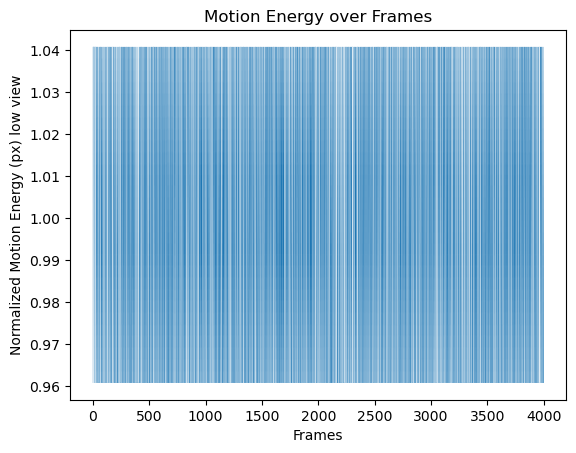

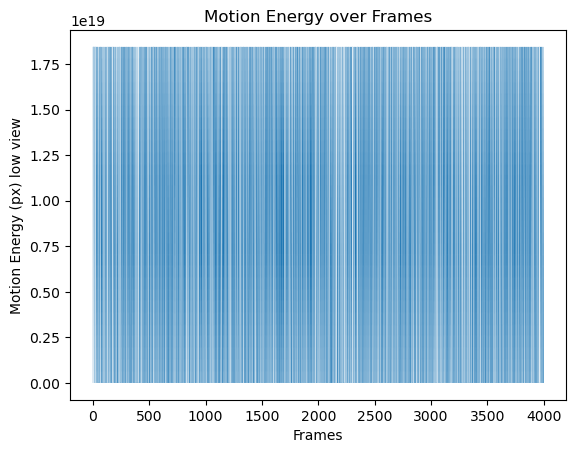

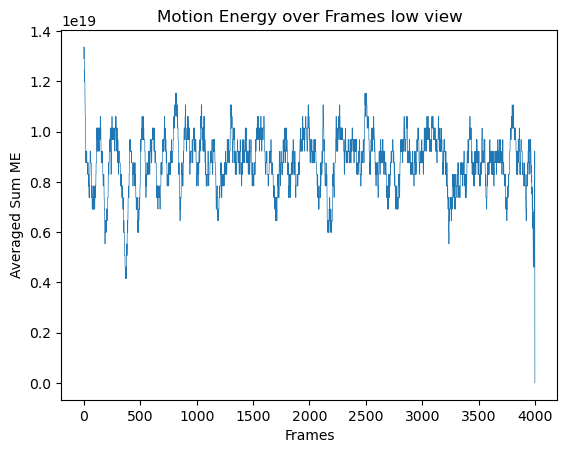

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
All arrays are cropped


/var/folders/26/vr_6h6_91zqdvg27bv5t8kgc0000gp/T/ipykernel_85060/2429174672.py:106: RuntimeWarning: overflow encountered in scalar subtract
  motion_energy = np.sum(df['Cropped_Frames'].iloc[idx + 1]) - np.sum(df['Cropped_Frames'][idx])


Motion Energy calculated on cropped_frames


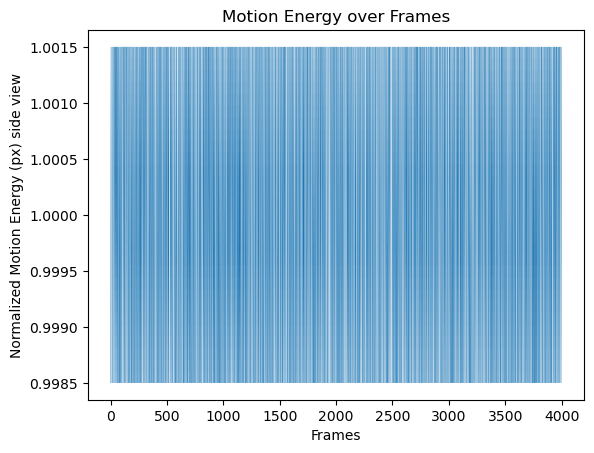

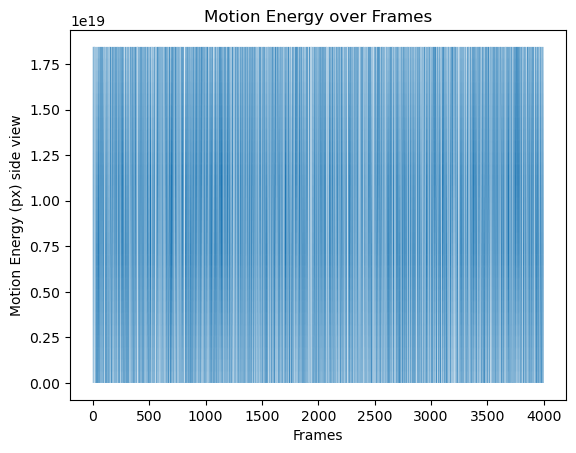

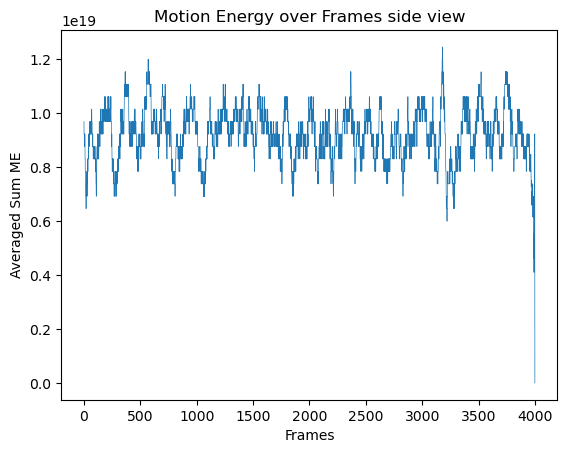

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
All arrays are cropped


/var/folders/26/vr_6h6_91zqdvg27bv5t8kgc0000gp/T/ipykernel_85060/2429174672.py:106: RuntimeWarning: overflow encountered in scalar subtract
  motion_energy = np.sum(df['Cropped_Frames'].iloc[idx + 1]) - np.sum(df['Cropped_Frames'][idx])


Motion Energy calculated on cropped_frames


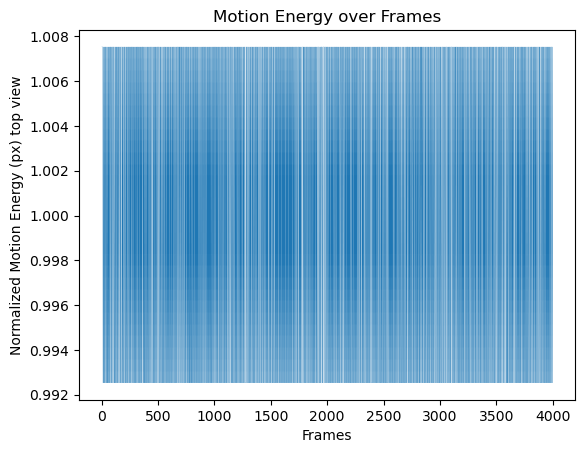

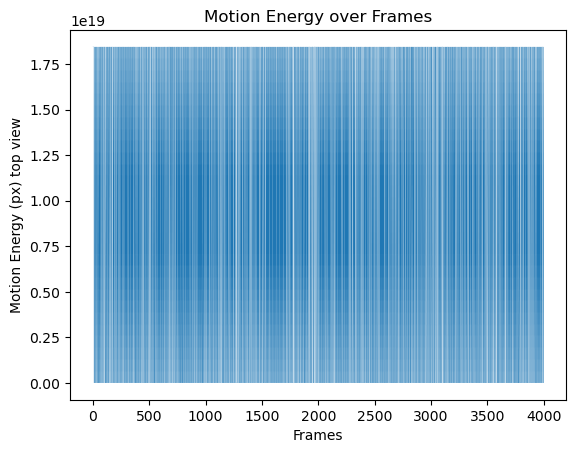

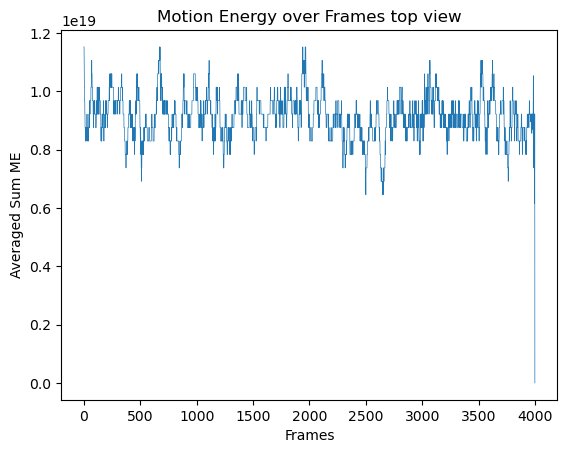

In [7]:
                                            #Load up videos and images - 9/10
v = 0

for movie in movies:
    # Load up frames
    frame_fraction = 0
    seconds_to_save = 20#60
    
    #Load video
    vid = imageio.get_reader(movie, 'ffmpeg')
    
    #Get fps, length, start frmae
    fps = vid.get_meta_data()['fps']
    length = fps*vid.get_meta_data()['duration']
    start_frame = int(frame_fraction * length)
    
    #initialize list to save each image in a frame
    stack_to_save = []
    rng = np.arange(int(start_frame), int(start_frame + fps*seconds_to_save))
    
    #Save each frame from video as image - tqdm just adds a progress bar
    for stk in tqdm(rng):
        stack_to_save.append(vid.get_data(stk))
    
    
    
    # Save out frames as image
    img_low_list = []
    #Converts each image to a single tif file with each image
    with tifffile.TiffWriter(os.path.split(movie_side)[0] + os.path.sep + os.path.split(movie_side)[1][:-4] + '-chunk.tif', imagej=True) as tif:
        for img in tqdm(stack_to_save):
             tif.write(img, contiguous=True)
    
    
                                            #Load frames and images into dataframe - 9/10
    
    #Label each frame and save into dataframe
    frame_num = list(range(len(stack_to_save)))
    frame_list = []
    for i in frame_num:
        frame_name = 'frame' + str(frame_num[i])
        frame_list.append(frame_name)
    
    #Create DataFrame
    df = pd.DataFrame()
    df['Frame_number'] = frame_list
    df['Frame_array'] = stack_to_save
    
    
                                                #Create ROI - 9/10
                                                     
    #Select random frame to choose ROI - roi in terms of [Top_Left_X, Top_Left_Y, Width, Height]
    random_frame = df.sample()
    img = random_frame['Frame_array'].iloc[0]
    roi = cv2.selectROI('Select ROI', img, showCrosshair=True, fromCenter=False)
    cv2.waitKey(0) 
    cv2.destroyAllWindows()
    
    #Get beginning and end indices for roi width
    roi_x1 = roi[0]
    roi_x2 = roi_x1 + roi[2]
    
    #Get beginning and end indices for roi height
    roi_y1 = roi[1]
    roi_y2 = roi_y1 + roi[3]
    
    
                                                        #Crop image array to ROI - 9/12
    
    list_array_cropped = []
    dict_array_cropped = {}
    
    #Iterate through each array and crop them
    for idx, row in df.iterrows():
        array = df['Frame_array'][idx]
    
        #Get height and width of image - should be the same 
        h_img, w_img, RGB = np.shape(array)
        #print(f'the width is {w_img}, the height is {h_img}')
    
        #Crop array by deleting anything before and after the roi height and width
        array_cropped = np.delete(array, list(range(roi_x2+1,w_img)),axis = 1)
        array_cropped = np.delete(array_cropped,list(range(0,roi_x1 - 1)), axis = 1)
        
        array_cropped = np.delete(array_cropped, list(range(roi_y2+1,h_img)),axis = 0)
        array_cropped = np.delete(array_cropped,list(range(0,roi_y1 - 1)), axis = 0)
    
        list_array_cropped.append(array_cropped)
        dict_array_cropped[df['Frame_number'][idx]] = array_cropped
        
    print(f'All arrays are cropped')
    
    df['Cropped_Frames'] = list_array_cropped
    
    
    
                                                        #Calculate Motion Energy - 9/10
    #Initialize Lists/Dicts
    dict_ME = {}
    list_ME = []
    list_ME_sum = []
    
    #Iterate thru rows and calculate motion energy between one row and the next row, used to be able to just use df[row] but I guess not now, chat gpt help
    for idx, row in df.iterrows():
        if idx + 1 < len(df):  # avoid going out of bounds
            motion_energy = np.sum(df['Cropped_Frames'].iloc[idx + 1]) - np.sum(df['Cropped_Frames'][idx])
            motion_energy = abs(motion_energy)
            #abs((df['Cropped_Frames'].iloc[idx + 1].sum()) - (df['Cropped_Frames'][idx].sum()))
            ME_sum = np.sum(motion_energy)
    
            #Save into list and dict
            dict_ME[df['Frame_number'][idx]] = motion_energy
            list_ME.append(motion_energy)
            list_ME_sum.append(ME_sum)
    
    #Add a fake row for length
    list_ME.append(0)
    list_ME_sum.append(0)
    
    #z_score motion energy.
    mean_ME = np.mean(list_ME) 
    std_ME = np.std(list_ME)
    norm_ME_list = [abs((ME - mean_ME)/std_ME) for ME in list_ME]
    
    print(f'Motion Energy calculated on cropped_frames')
    
    #Add motion energy to dataframe 
    df['Motion Energy'] = list_ME
    df['Motion Energy Sum'] = list_ME_sum
    df['Normalized Motion Energy'] = norm_ME_list
    
    
    
                                                            #Plot Motion Energy - 9/15
    
    #Set axes 
    x_axis = range(len(norm_ME_list))
    y_axis = norm_ME_list
    
    #Plot and set labels 
    plt.plot(x_axis,y_axis, linewidth = 0.1)
    
    plt.title("Motion Energy over Frames")
    plt.xlabel("Frames")
    plt.ylabel(f"Normalized Motion Energy (px) {view[v]} view")
    plt.savefig(f'{plots}Normalized_ME_{view[v]}.png')
    plt.show()
    plt.close()

    y_axis = list_ME
    
        #Plot and set labels 
    plt.plot(x_axis,y_axis, linewidth = 0.1)
    
    plt.title("Motion Energy over Frames")
    plt.xlabel("Frames")
    plt.ylabel(f"Motion Energy (px) {view[v]} view")
    plt.savefig(f'{plots}ME_{view[v]}.png')
    plt.show()
    plt.close()
    
    
    #Plot by averaging values every 10 frames using moving window 
    
    #Make window size
    wind_size = 40 
    mean_list = []
    
    #Iterate through the list you want
    for i in range(len(list_ME_sum)):
    
        #basically making a sublist that indexes through the value you're at to the value at the end of your window size and doing whatever you want to that sublist
        mean = np.mean(list_ME_sum[i:i + wind_size])
        #Make sure to save it 
        mean_list.append(mean)
    
    mean_list
    
    
    plt.plot(range(len(mean_list)),mean_list,linewidth = 0.5)
    plt.xlabel('Frames')
    plt.ylabel('Averaged Sum ME')
    plt.title(f'Motion Energy over Frames {view[v]} view')
    #plt.savefig(f'{plots}_ME_{view[v]}.png')
    plt.show()

    v +=1


In [17]:
ME_test_sum = np.sum(df['Cropped_Frames'][0][0][0])
#ME_test = abs(np.diff(ME_test_sum,append=0))

ME_test_sum

254

                                                                **Notes**

Numpy Array shape order:(H, W, D) i.e. (height, width, depth) for images because of the terminology that numpy uses for ndarrays (axis=0, axis=1, axis=2) or analogously (Y, X, Z) if one would like to visualize in 3 dimensions.


Turn arrays into images to sanity check with Pillow Image - test_image = Image.fromarray(test_array_del) 

roi in terms of Top_Left_X coord, Top_Left_Y coord, Width, Height. So you need to calculate the other coordinates from the width and height 

Make a moving window, how does it not run into a index out of range error? 
- Basically making a sublist that indexes through the value you're at to the value at the end of your window size and doing whatever you want to that sublist as you iterate through your main list


In [87]:
# Play around with other data
df_csv = pd.read_csv(csv_side)
df_csv

,Side Camera,100047,LED,1734307152.7969837
0,Side Camera,219591,LED,1.734308e+09
1,Side Camera,219844,LED,1.734308e+09
2,Side Camera,219869,LED,1.734308e+09
3,Side Camera,264160,LED,1.734308e+09
4,Side Camera,264333,LED,1.734308e+09
5,Side Camera,276671,LED,1.734308e+09
6,Side Camera,277800,LED,1.734308e+09
7,Side Camera,290116,LED,1.734308e+09
8,Side Camera,304257,LED,1.734308e+09
9,Side Camera,320515,LED,1.734308e+09
